## City of Los Angeles - Traffic Collision Analysis

### Abstract:

This project aims to perform an Exploratory Data Analysis (EDA) on the Traffic Collision data obtained from the City of Los Angeles Police Department. This dataset reflects traffic collision incidents in the City of LA dating back to 2010 to present. As part of the EDA, we plan to clean the data, explore summary statistics, identify trends, and render interpretations over various features by creating visualizations.


### Source: 

https://data.lacity.org/Public-Safety/Traffic-Collision-Data-from-2010-to-Present/d5tf-ez2w

#### Importing Required libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set_theme(style = 'darkgrid')
%matplotlib inline

#### Importing the csv file to a dataframe

In [2]:
tc = pd.read_csv("COLA_TC.csv")
print(f'{tc.shape[0]} rows and {tc.shape[1]} columns have been imported')

565256 rows and 18 columns have been imported


In [3]:
#Different Features of the dataset include
tc.columns

Index(['DR Number', 'Date Reported', 'Date Occurred', 'Time Occurred',
       'Area ID', 'Area Name', 'Reporting District', 'Crime Code',
       'Crime Code Description', 'MO Codes', 'Victim Age', 'Victim Sex',
       'Victim Descent', 'Premise Code', 'Premise Description', 'Address',
       'Cross Street', 'Location'],
      dtype='object')

In [4]:
# Renaming Columns
# All demographic information pertains to victim only.

tc = tc.rename(columns = {'Date Occurred':'Date_Occurred',
                     'Time Occurred': 'Time_Occurred',
                     'Area Name':'Area_Name',
                     'Reporting District':'District',
                     'Victim Age':'Age',
                     'Victim Sex': 'Sex',
                     'Victim Descent':'Descent',
                     'Premise Description':'Premise'})

# Changing the datatypes of the columns
tc = tc.astype({'Date_Occurred':'string',
                'Time_Occurred':'string',
                'Area_Name':'category',
                'District':'category',
                'Sex':'category',
                'Descent':'category',
                'Premise':'category'
               })

In [5]:
# Combining Date Occurred & Time Occured 
tc['Time_Occurred'] = tc['Time_Occurred'].apply(lambda x: x[0:len(x)-2].zfill(2) + ":" + x[len(x)-2:])
tc['Date_Occurred'] = tc['Date_Occurred'] + ' ' + tc['Time_Occurred']

In [6]:
tc['Date_Occurred'] = pd.to_datetime(tc['Date_Occurred'])
tc['Year'] = tc['Date_Occurred'].dt.year
tc['Month'] = tc['Date_Occurred'].dt.month
tc['Day'] = tc['Date_Occurred'].dt.day
tc['Weekday'] = tc['Date_Occurred'].dt.dayofweek
# 0 is Monday ----> 6 is Sunday

In [7]:
#Converting Location to Latiude and Longitudinal Coordinates
tc[['Latitude','Longitude']] = tc.Location.str.split(',', expand = True)
tc.Latitude = pd.to_numeric(tc.Latitude.apply(lambda x:x[1:]))
tc.Longitude = pd.to_numeric(tc.Longitude.apply(lambda x:x[:-2]))

In [8]:
#Dropping unnecessary columns from the dataframe
tc = tc.drop(['DR Number','Area ID','Crime Code','Crime Code Description','MO Codes','Premise Code','Address','Time_Occurred','Cross Street','Date Reported','Location'],axis = 1)

In [9]:
#Dropping Nan Values from the Dataframe Columns => Sex, Descent & Premise
tc.dropna(subset = ['Sex','Descent','Premise'], inplace = True)
# Dropping rows with Uncategorized descent
tc = tc[tc.Descent != '-']
# Dropping rows with Uncategorized Sex
tc = tc[tc.Sex.isin(['H','N']) == False]
# Replacing NaN values in Age with Average Age
tc.Age = tc.Age.fillna(tc.groupby(['Area_Name','Sex','Descent'])['Age'].transform('mean'))
# Dropping any misc. NaN values in Age
tc.dropna(subset = ['Age'], inplace = True)
# Convert age to integer 
tc['Age'] = tc['Age'].astype(int)

In [10]:
tc.head()

,Date_Occurred,Area_Name,District,Age,Sex,Descent,Premise,Year,Month,Day,Weekday,Latitude,Longitude
0,2019-08-24 04:50:00,Southwest,356,22,M,H,STREET,2019,8,24,5,34.0255,-118.300
1,2019-08-30 23:20:00,Southwest,355,30,F,H,STREET,2019,8,30,4,34.0256,-118.308
2,2019-08-25 05:45:00,Hollenbeck,422,37,M,X,STREET,2019,8,25,6,34.0738,-118.207
3,2019-11-20 03:50:00,Central,128,21,M,H,STREET,2019,11,20,2,34.0492,-118.239
4,2019-08-30 21:00:00,Southwest,374,49,M,B,STREET,2019,8,30,4,34.0108,-118.318


In [11]:
list(tc.columns)

['Date_Occurred',
 'Area_Name',
 'District',
 'Age',
 'Sex',
 'Descent',
 'Premise',
 'Year',
 'Month',
 'Day',
 'Weekday',
 'Latitude',
 'Longitude']

## Summary Statistics

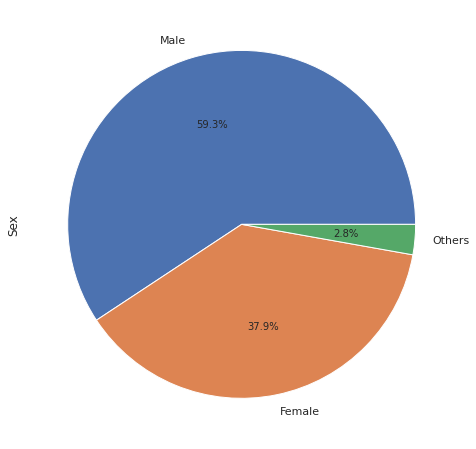

In [12]:
# Distribution between Sex, maybe more drivers are male, how to normalize it???
Sex_tc = tc.Sex.value_counts()
Sex_tc.drop(labels = ['H','N'],inplace = True)
Sex_tc.index = ['Male','Female','Others']
Sex_tc.plot.pie(y = 'count', shadow = False, figsize = (8,8), autopct = '%1.1f%%')
plt.savefig('HD_Images/PieChart.png', dpi = 600)
plt.show()

In [13]:
# average age by sex
ageBySex = tc[['Sex','Age']].groupby('Sex').mean()
ageBySex.drop(labels = ['H','N'],inplace = True)
ageBySex

,Age
Sex,
F,40.266953
M,42.223428
X,38.586342


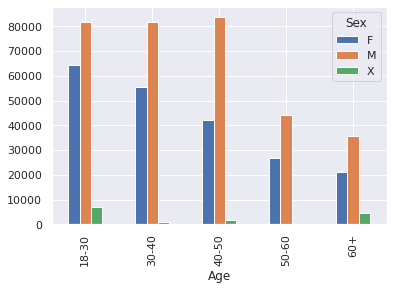

In [14]:
# collision counts by age and gender (F and M only), put age to categories
age_group = pd.cut(tc.Age, bins=[18, 30, 40, 50, 60, np.Inf], labels = ['18-30', '30-40', '40-50', '50-60', '60+'])
#plt.figure(figsize=(15, 15))
# pl = sns.countplot(x='Age_group', data=tc[tc.Sex.isin(['F','M'])], hue = 'Sex')
# pl.set(title='Collisions by Age Group', xlabel = 'Age Group')
# plt.show()
pd.crosstab(age_group, tc['Sex']).plot(kind = 'bar')
plt.savefig('HD_Images/Age_Distribution.png', dpi = 600,bbox_inches = "tight")
plt.show()

## Summary Plots

#### Count of Total number of Traffic Incidents over the last Decade


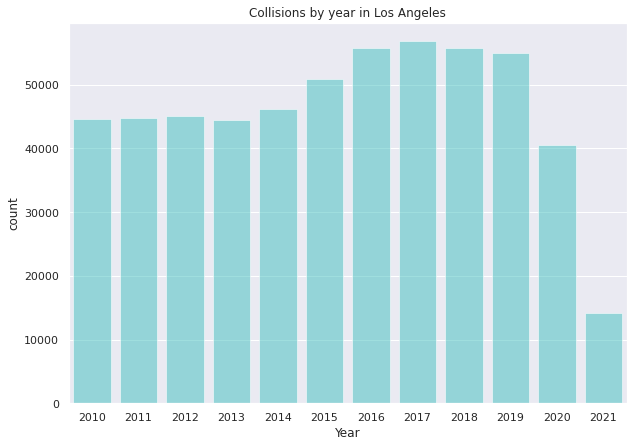

In [15]:
# why 2017 has the most traffic collisions??
f,ax = plt.subplots(figsize = (10,7))
sns.countplot(data = tc, x = 'Year', saturation = 0.5, color = 'cyan', alpha = 0.5)
ax.set_title("Collisions by year in Los Angeles")
plt.savefig('HD_Images/Year_Distribution.png', dpi = 600,bbox_inches = "tight")

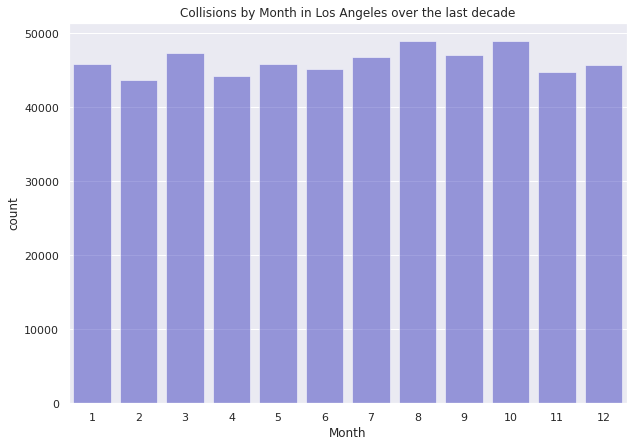

In [16]:
tc = tc
f,ax = plt.subplots(figsize = (10,7))
sns.countplot(data = tc, x = 'Month', saturation = 0.5, alpha = 0.5, color = 'blue')
ax.set_title("Collisions by Month in Los Angeles over the last decade")
plt.savefig('HD_Images/Month_Distribution.png', dpi = 600,bbox_inches = "tight")

<function matplotlib.pyplot.show(close=None, block=None)>

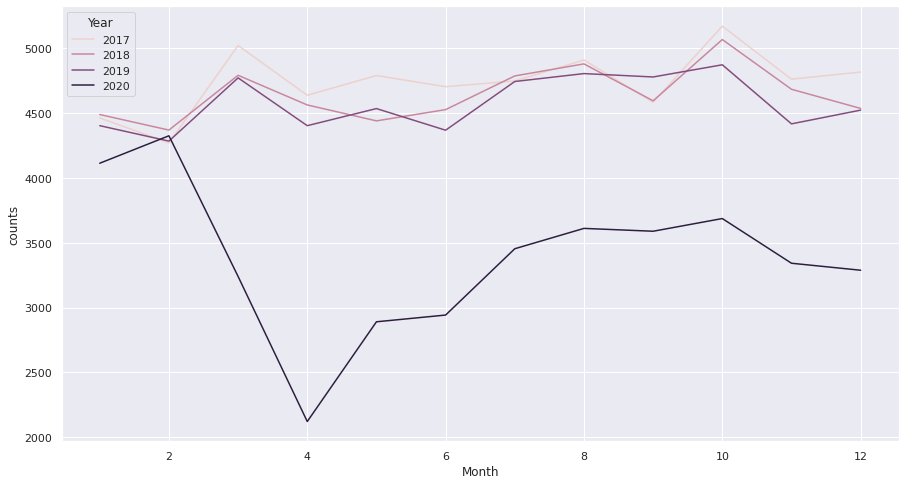

In [17]:
# collision line plots by month for 2018, 2019 and 2020
tcYearMonth = tc.groupby(['Year', 'Month']).size().reset_index(name='counts')
tcYearMonth['Year'] = tcYearMonth.astype('category')
years = [2017, 2018, 2019, 2020]

plt.figure(figsize = (15,8))
sns.lineplot(x='Month', y='counts', hue='Year', data=tcYearMonth[tcYearMonth['Year'].isin(years)])
plt.savefig('HD_Images/Month_17-20.png', dpi = 600,bbox_inches = "tight")
plt.show

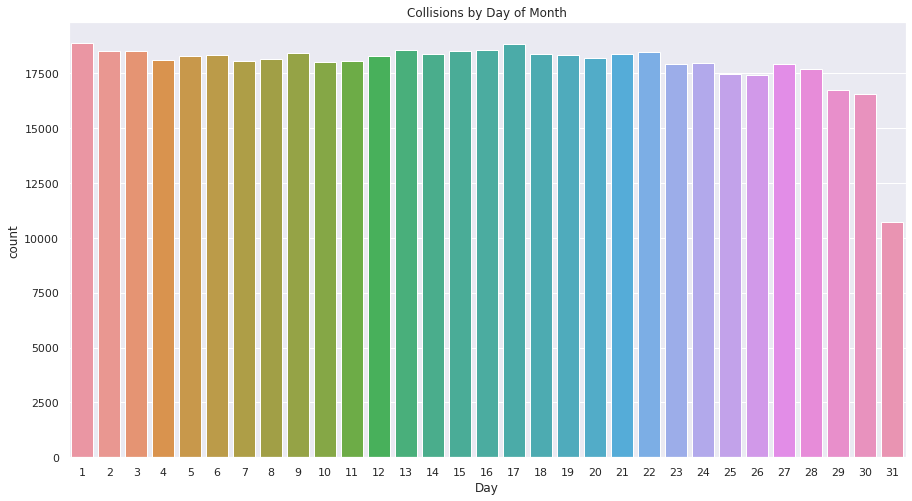

In [18]:
# collisions by day of the month 
plt.figure(figsize=(15, 8))
pl = sns.countplot(x='Day', data=tc)
pl.set(title='Collisions by Day of Month', xlabel = 'Day')
plt.savefig('HD_Images/Distribution_Day_Month', dpi = 600,bbox_inches = "tight")
plt.show()

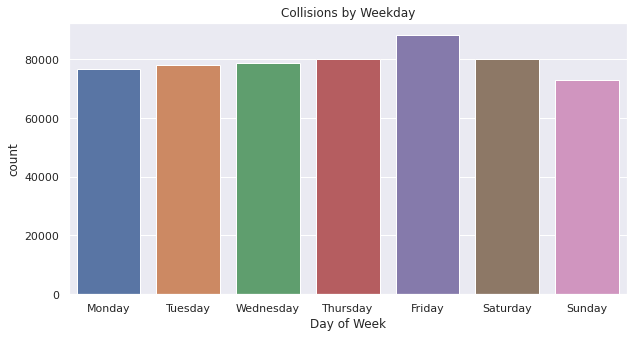

In [19]:
# collisions by weekday
plt.figure(figsize=(10,5))
tc['Weekday2'] = tc['Date_Occurred'].dt.strftime('%A')
weekDayOrder = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pl = sns.countplot(x='Weekday2', data=tc, order=weekDayOrder)
pl.set(title='Collisions by Weekday', xlabel = 'Day of Week')
plt.savefig('HD_Images/Weekday.png', dpi = 600,bbox_inches = "tight")
plt.show()

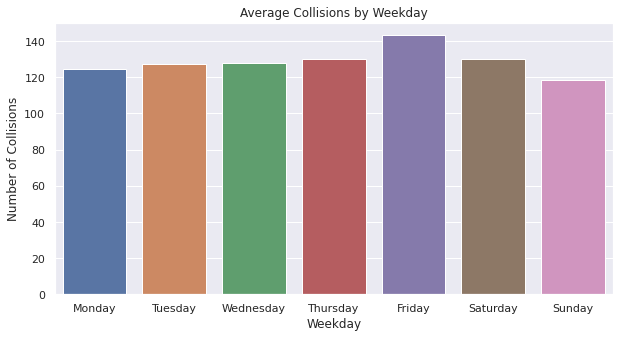

In [20]:
# average collisions by weekday since there might be more Fridays than other weekdays, the trend matches with the total number plot
tc['Date'] = tc['Date_Occurred'].dt.date
df = tc.Date.value_counts().reset_index()
df['weekDay'] = pd.to_datetime(df['index']).dt.strftime('%A')
avgCollisions = df.groupby(['weekDay'])['Date'].mean().reset_index()

plt.figure(figsize = (10,5))
pl = sns.barplot(x='weekDay', y = 'Date', 
                  order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                  data=avgCollisions)
pl.set(title='Average Collisions by Weekday', xlabel = 'Weekday', ylabel = 'Number of Collisions')
plt.savefig('HD_Images/Weekday_Average.png', dpi = 600,bbox_inches = "tight")
plt.show()

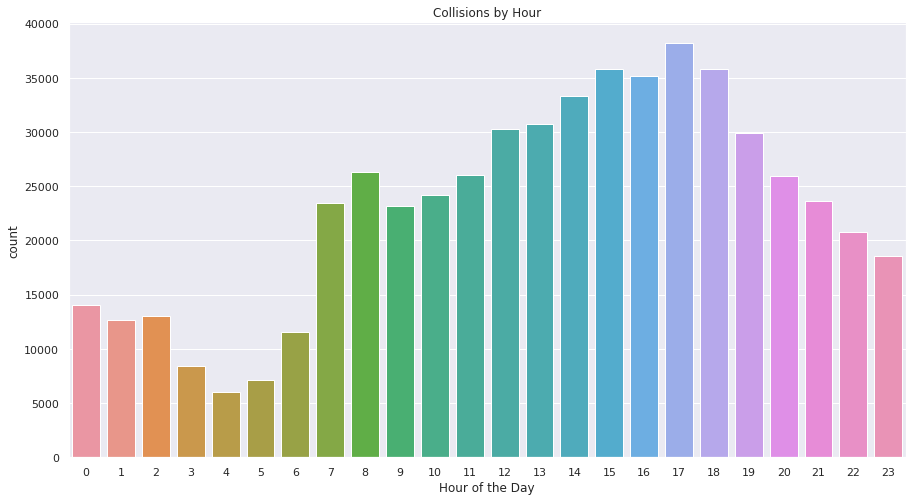

In [22]:
# collisions by hour of the day
plt.figure(figsize=(15,8))
tc['Hour'] = tc['Date_Occurred'].dt.hour
pl = sns.countplot(x='Hour', data = tc)
pl.set(title='Collisions by Hour', xlabel = 'Hour of the Day')
plt.savefig('HD_Images/Hour_of_Day.png', dpi = 600,bbox_inches = "tight")
plt.show()

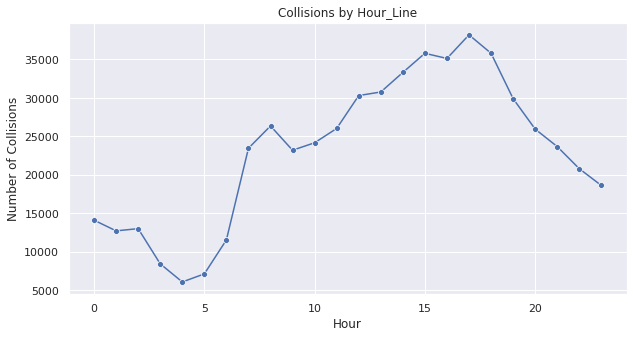

In [23]:
# collisions by hours line plot, merge line plot with bar plot??
hourCountsDF = tc.Hour.value_counts().reset_index(name='Count')
plt.figure(figsize=(10,5))
pl = sns.lineplot(x='index', y = 'Count', marker="o", data=hourCountsDF)
pl.set(title='Collisions by Hour_Line', xlabel = 'Hour', ylabel = 'Number of Collisions')
plt.show()

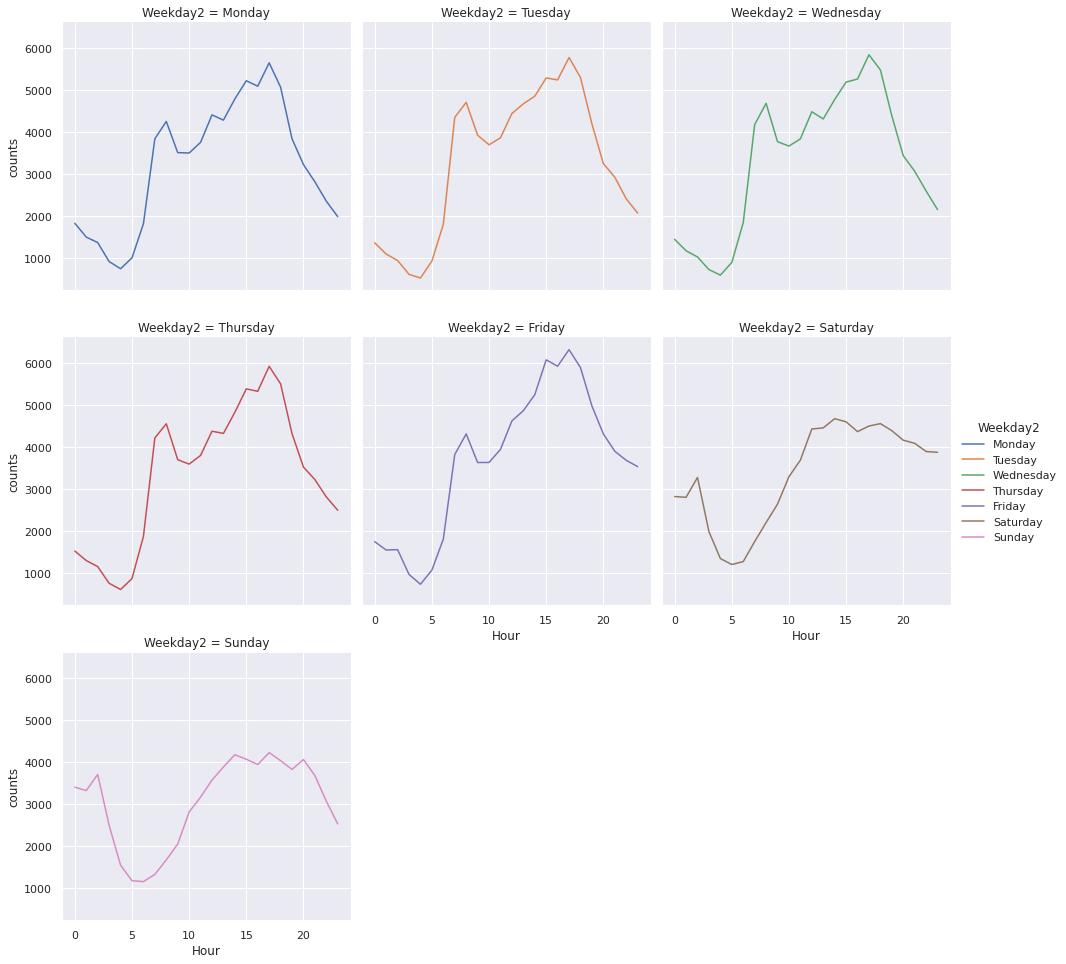

In [24]:
# facet grid to show weekday collisions by hour
tcDayHour = tc.groupby(['Weekday2','Hour']).size().reset_index(name='counts')
tcDayHour['Weekday2'] = pd.Categorical(tcDayHour['Weekday2'],
                                   categories=weekDayOrder,
                                   ordered=True)
g = sns.FacetGrid(tcDayHour, hue="Weekday2", col="Weekday2",sharey=True,col_wrap=3,height=4.5, aspect=1)
g = g.map(sns.lineplot, "Hour", "counts")
g.add_legend()
plt.savefig('HD_Images/Day_Hour_Combo.png', dpi = 600,bbox_inches = "tight")

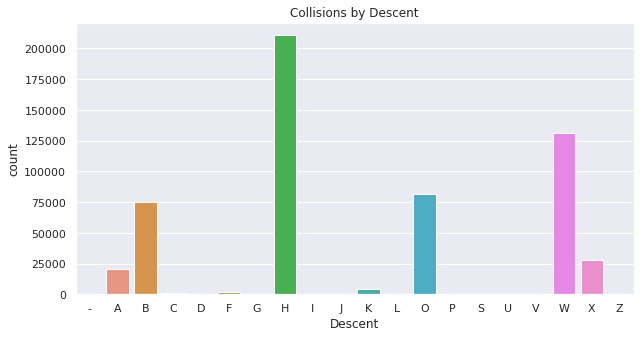

In [25]:
# collisions by descent, A is Asian, B is black, H is hispanic, O is other, W is white and X is unknown. 
plt.figure(figsize=(10, 5))
pl = sns.countplot(x='Descent', data=tc)
pl.set(title='Collisions by Descent', xlabel = 'Descent')
plt.savefig('HD_Images/Collissions_by_Descent.png', dpi = 600,bbox_inches = "tight")
plt.show()

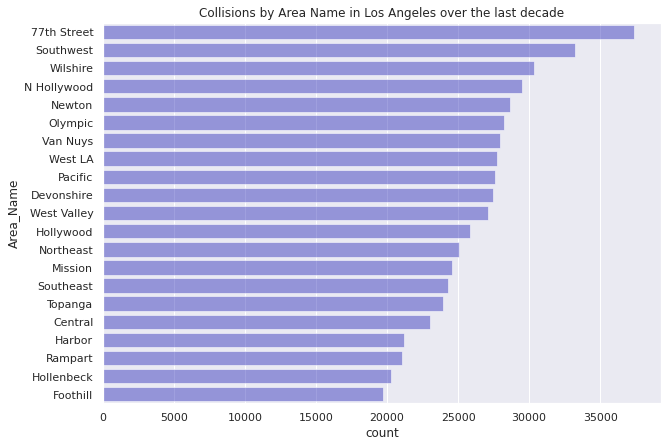

In [26]:
# collisions by locations
f,ax = plt.subplots(figsize = (10,7))
DO_area = tc.Area_Name.value_counts().sort_values(ascending = False).index
sns.countplot(data = tc, y = 'Area_Name', saturation = 0.5, alpha = 0.5, order = DO_area, color = 'blue')
ax.set_title("Collisions by Area Name in Los Angeles over the last decade")
plt.savefig('HD_Images/Collissions_by_Area.png', dpi = 600,bbox_inches = "tight")

In [27]:
#Importing Street Map of LA City, why picked 2019??? 
lacity_map = gpd.read_file('Map/City_Boundaries.shp')

#Designating Coordinate System
#crs = {'init':'espc:4326'}
tc_2019 = tc[tc['Year']==2019]

# zip x and y coordiantes into single feature
geometry = [Point(xy) for xy in zip(tc_2019.Longitude, tc_2019.Latitude)]

# Create GeoPandas Dataframe
gdf_2019 = gpd.GeoDataFrame(tc_2019, geometry = geometry)

gdf_2019.head()

,Date_Occurred,Area_Name,District,Age,Sex,Descent,Premise,Year,Month,Day,Weekday,Latitude,Longitude,Weekday2,Date,Hour,geometry
0,2019-08-24 04:50:00,Southwest,356,22,M,H,STREET,2019,8,24,5,34.0255,-118.300,Saturday,2019-08-24,4,POINT (-118.30000 34.02550)
1,2019-08-30 23:20:00,Southwest,355,30,F,H,STREET,2019,8,30,4,34.0256,-118.308,Friday,2019-08-30,23,POINT (-118.30800 34.02560)
2,2019-08-25 05:45:00,Hollenbeck,422,37,M,X,STREET,2019,8,25,6,34.0738,-118.207,Sunday,2019-08-25,5,POINT (-118.20700 34.07380)
3,2019-11-20 03:50:00,Central,128,21,M,H,STREET,2019,11,20,2,34.0492,-118.239,Wednesday,2019-11-20,3,POINT (-118.23900 34.04920)
4,2019-08-30 21:00:00,Southwest,374,49,M,B,STREET,2019,8,30,4,34.0108,-118.318,Friday,2019-08-30,21,POINT (-118.31800 34.01080)


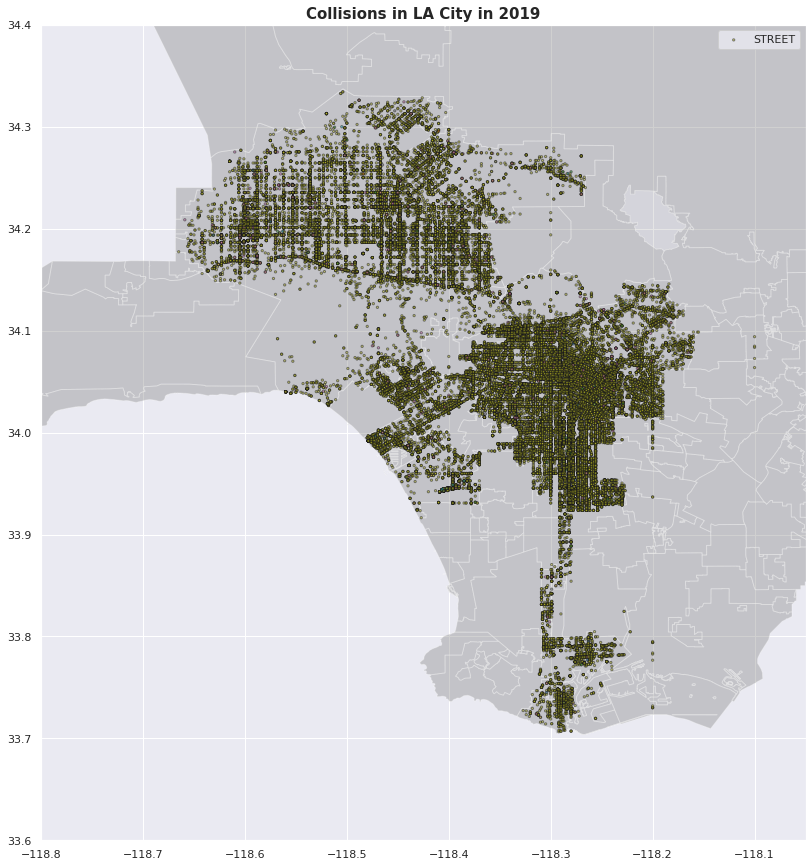

In [28]:
# Creating figure and axes, assign to subplot
fig, ax = plt.subplots(figsize = (15,15))

# Adding .shp map file to axes
lacity_map.plot(ax = ax, alpha = 0.2, color = 'grey')

gdf_2019.plot(column = 'Premise',ax = ax, alpha = 0.50, legend = True, markersize = 5, edgecolor = 'k')

#Add title to the graph
plt.title('Collisions in LA City in 2019', fontsize = 15, fontweight = 'bold')
plt.legend(['STREET'])
#Set latitude and longitude boundaries of map display
plt.xlim(-118.8,-118.05)
plt.ylim(33.6,34.40)

#show Map
plt.show()

In [29]:
tc.head()

,Date_Occurred,Area_Name,District,Age,Sex,Descent,Premise,Year,Month,Day,Weekday,Latitude,Longitude,Weekday2,Date,Hour
0,2019-08-24 04:50:00,Southwest,356,22,M,H,STREET,2019,8,24,5,34.0255,-118.300,Saturday,2019-08-24,4
1,2019-08-30 23:20:00,Southwest,355,30,F,H,STREET,2019,8,30,4,34.0256,-118.308,Friday,2019-08-30,23
2,2019-08-25 05:45:00,Hollenbeck,422,37,M,X,STREET,2019,8,25,6,34.0738,-118.207,Sunday,2019-08-25,5
3,2019-11-20 03:50:00,Central,128,21,M,H,STREET,2019,11,20,2,34.0492,-118.239,Wednesday,2019-11-20,3
4,2019-08-30 21:00:00,Southwest,374,49,M,B,STREET,2019,8,30,4,34.0108,-118.318,Friday,2019-08-30,21


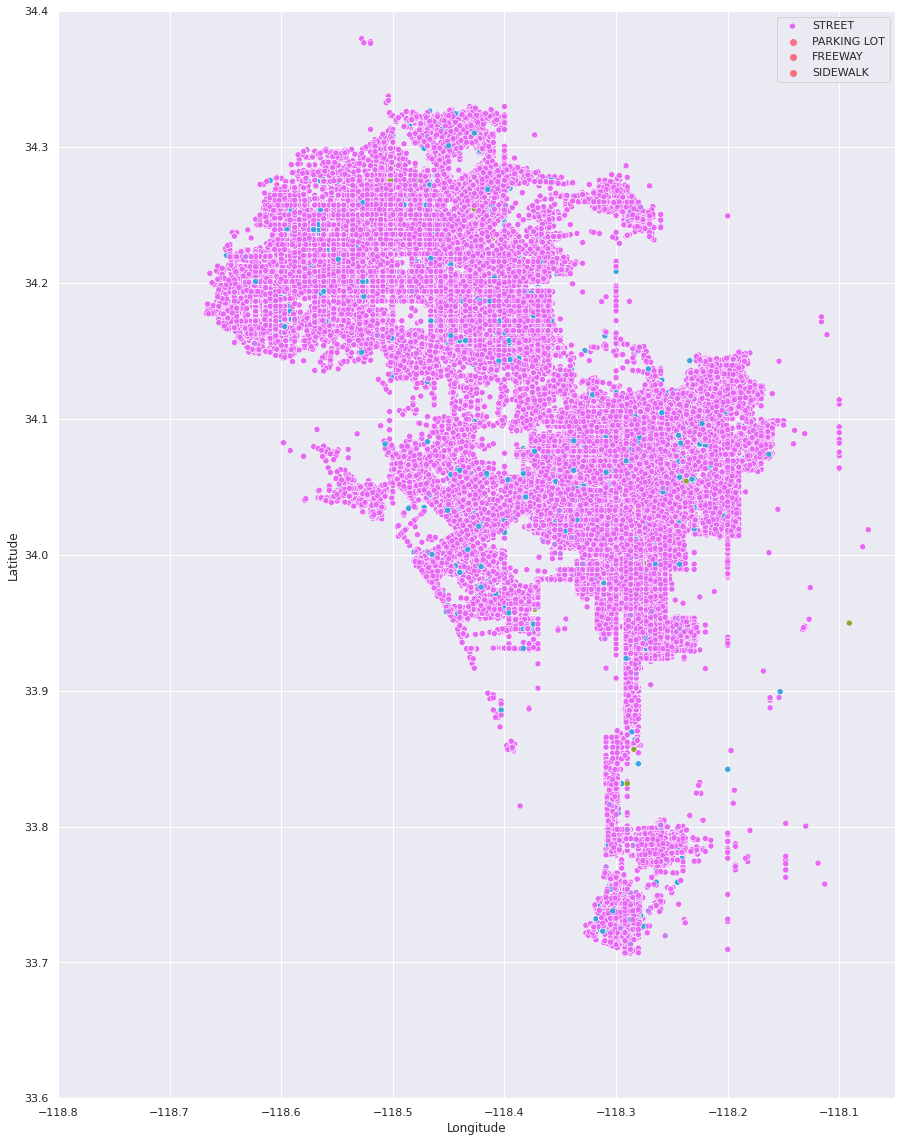

In [30]:
plt.figure(figsize=(15,20))
tc_premise=tc[(tc["Premise"]=='STREET')|(tc["Premise"]=='PARKING LOT')|(tc["Premise"]=='FREEWAY')|
        (tc["Premise"]=='SIDEWALK')]
ax=sns.scatterplot(x="Longitude", y="Latitude", hue="Premise",data=tc_premise, legend = True)
ax.legend(['STREET','PARKING LOT', 'FREEWAY','SIDEWALK'])
plt.xlim(-118.80,-118.05)
plt.ylim(33.6,34.40)
plt.savefig('HD_Images/Collissions_by_Premise.png', dpi = 600,bbox_inches = "tight")

In [31]:
import folium
from IPython.display import HTML
from folium.plugins import HeatMap

In [32]:
map_la = folium.Map(location=(34.052235,-118.243683), control_scale=True, zoom_start = 10) 

# Create the HeatMap then add to base_map
HeatMap(data=tc[['Latitude','Longitude']].groupby(['Latitude','Longitude']).sum().reset_index().values.tolist(), radius=7, max_zoom=10, gradient = {0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(map_la)

# display map
map_la